In [13]:
import numpy as np
import pandas as pd
import multiprocessing


from scipy.stats import norm
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

multiprocessing.set_start_method("fork")

In [14]:
# Initial parameters
mu = 13
variance = 3
T = 300
phi = 0.1

In [15]:
def simulate_ar_process(mu: float, variance: float, phi: float, T: int) -> list:
    current_val = mu
    observations = []
    observations.append(current_val)

    for _ in range(1, T):
        noise = norm.rvs(0, variance)
        current_val = mu + phi * (current_val - mu) + noise 
        observations.append(current_val)

    return observations

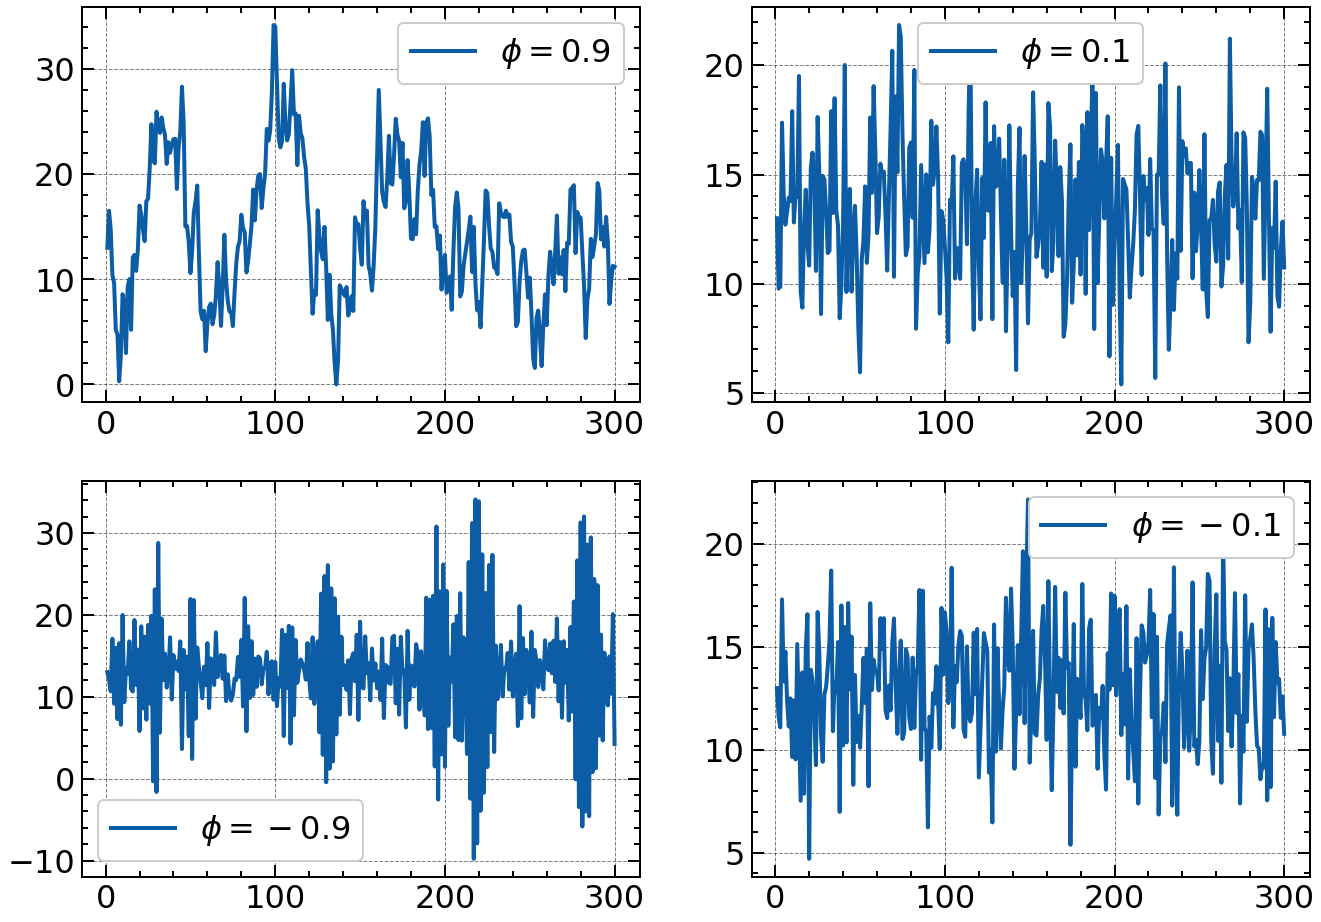

In [25]:
t = range(1, T+1)
observations1 = simulate_ar_process(mu, variance, 0.9, T)
observations2 = simulate_ar_process(mu, variance, 0.1, T)
observations3 = simulate_ar_process(mu, variance, -0.1, T)
observations4 = simulate_ar_process(mu, variance, -0.9, T)


fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(t, observations1, label='$\phi = 0.9$')
axs[0, 0].legend()
axs[0, 1].plot(t, observations2, label='$\phi = 0.1$')
axs[0, 1].legend()

axs[1, 0].plot(t, observations4, label='$\phi = -0.9$')
axs[1, 0].legend()
axs[1, 1].plot(t, observations3, label='$\phi = -0.1$')
axs[1, 1].legend()

fig.set_size_inches(11, 8)
plt.show()

In [17]:
synthetic_data_x = simulate_ar_process(mu, variance, 0.2, T)
synthetic_data_y = simulate_ar_process(mu, variance, 0.95, T)

Treating the parameters $\mu$, $\sigma^2$ and $\phi$ as random variables with prior distributions, we can make use of PyStan or PyMC3 in order to do inference. In our case we use the pystan package. 

The prior distributions of the parameters are non-informative flat priors, i.e. constants on their respective support. 

In [18]:
model = """
data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
  real <lower=0> sigma2;
  real<lower=-1, upper=1> phi;
}
model {
  for (n in 2:N) {
    y[n] ~ normal(mu + phi * (y[n-1] - mu), sigma2);
  }
}"""

In [21]:
import pystan 
stan_model = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8fc488e37b1f795d25268d933256da44 NOW.
In file included from /var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/pystan_27w4mxbi/stanfit4anon_model_8fc488e37b1f795d25268d933256da44_5017036346059764342.cpp:777:
In file included from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In [33]:
model_1_data = {"N": 300, "y": np.array(synthetic_data_x)}
df1 = stan_model.sampling(data=model_1_data, iter=5000)
df1


Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%

Inference for Stan model: anon_model_8fc488e37b1f795d25268d933256da44.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      13.19  2.1e-3   0.21  12.77  13.05  13.19  13.33  13.61  10354    1.0
sigma2   3.04  1.2e-3   0.13    2.8   2.95   3.03   3.12    3.3  10595    1.0
phi      0.16  5.8e-4   0.06   0.05   0.12   0.16    0.2   0.28   9876    1.0
lp__   -480.5    0.02   1.25 -483.8 -481.0 -480.1 -479.6 -479.0   4916    1.0

Samples were drawn using NUTS at Thu May 26 04:19:38 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [34]:
model_2_data = {"N": 300, "y": np.array(synthetic_data_y)}
df2 = stan_model.sampling(data=model_2_data, iter=5000)
df2



Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!



Iteration:    1 / 5000 [  0%]  (Warmup)
Gradient evaluation took 3.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%

Iteration: 5000 / 5000 [100%]  (Sampling)

 Elapsed Time: 0.728201 seconds (Warm-up)
               12.3879 seconds (Sampling)
               13.1161 seconds (Total)



Inference for Stan model: anon_model_8fc488e37b1f795d25268d933256da44.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -5.9e5   8.2e5  4.2e6 -1.4e7 -131.4  14.38  34.41  3.2e6     26   1.19
sigma2   3.14    0.02   0.14   2.89   3.04   3.13   3.23   3.38     57   1.05
phi      0.98    0.02   0.03   0.92   0.96    1.0    1.0    1.0      3   1.67
lp__   -495.6     4.1   6.88 -508.4 -501.3 -496.1 -488.7 -487.1      3   1.98

Samples were drawn using NUTS at Thu May 26 04:20:03 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

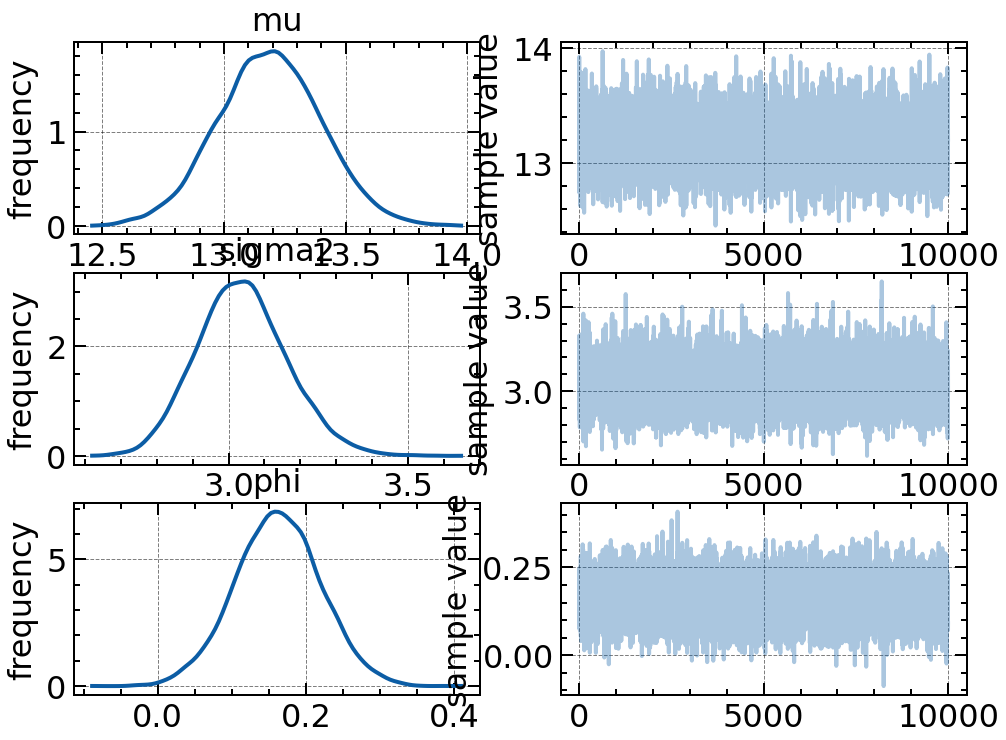

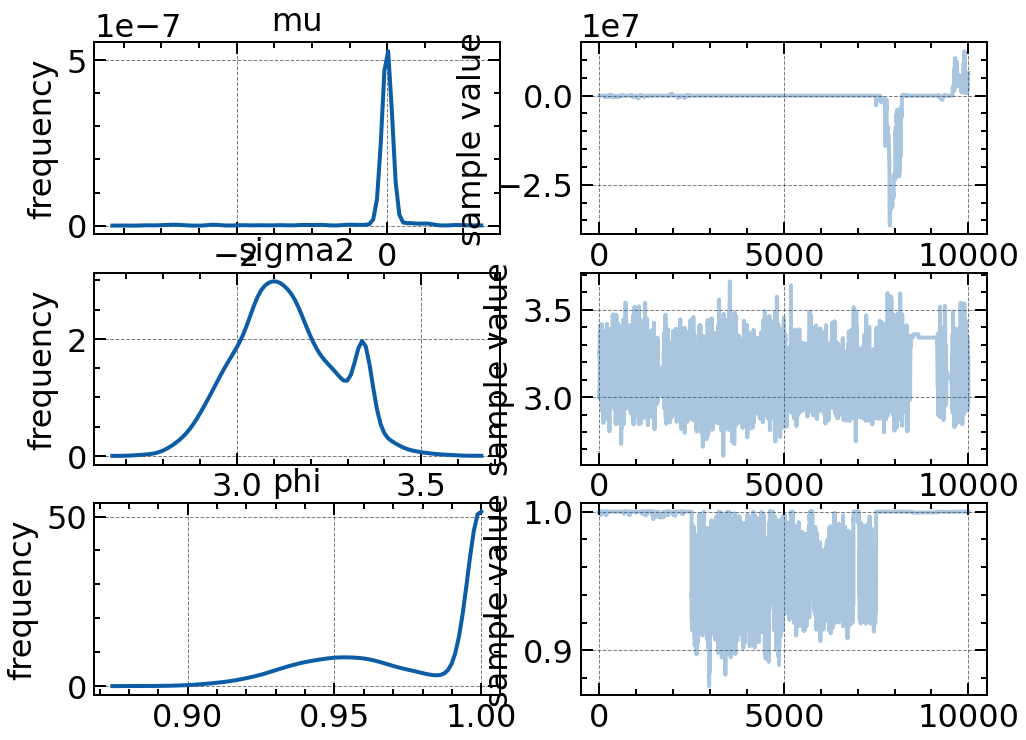

In [41]:
df1.to_dataframe()
df1.plot()
df2.plot()
fig.tight_layout()
plt.show()